Целью данного аналитического проекта является разработка решения, которое позволит персонализировать предложения постоянным клиентам для увеличения их покупательской активности.

Заказчик: интернет-магазин "В один клик", занимающейся продажей разных товаров (от детских до бытовой техники и продуктов).

Большая часть целевой аудитории уже осведомлена о магазине, в связи с чем проблематично увеличить продажи за счет привлечения новых клиентов.

Предварительно необходимо:
- Промаркировать уровень финансовой активности постоянных покупателей (снизилась, если клиент покупает меньше товаров, или прежний уровень).
- Сгруппировать данные по клиентам по следующим категориям:
    - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
    - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
    - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
    - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

После необходимо:
- Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- Включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler  
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.inspection import permutation_importance

## Загрузка данных

Загрузим необходимые данные:
- market_file.csv (market) содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- market_money.csv (m_money) содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- market_time.csv (m_time.csv) содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- money.csv (money) содержит данные о среднемесячной прибыли с покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [2]:
try:
    market = pd.read_csv('/datasets/market_file.csv')
    m_money = pd.read_csv('/datasets/market_money.csv')
    m_time = pd.read_csv('/datasets/market_time.csv')
    money = pd.read_csv('/datasets/money.csv', sep=';')
except:
    market = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    m_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    m_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';')

Проверим, что данные в датасетах соответствуют описанию.

In [3]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [4]:
m_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [5]:
m_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [6]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


Отметим следующее:

- market:
    - Отмечаем проблему в типах данных ("Разрешить сообщать" имеет тип "строки", хотя ожидается булевый тип данных).
    - Пропусков в данных нет.
    
- m_money:
    - Типы данных соответствуют ожидаемым.
    - Пропусков в данных нет.
    
- m_time:
    - Типы данных соответствуют ожидаемым.
    - Пропусков в данных нет.

- money:
    - Отмечаем проблему в типах данных ("Прибыль" имеет тип "строки", хотя ожидается целочисленный или вещественный).
    - Пропусков в данных нет.

## Преобработка данных

Подготовим данные для дальнейшнего анализа. Ранее уже отметили отсутствие пропусков в данных.

Рассмотрим данные на наличие неявных и явных дубликатов в данных.

In [7]:
#в датасете market рассмотрим столбцы Покупательская активность, Тип сервиса, Популярная_категория
print('Данные о покупательской активности', market['Покупательская активность'].unique())
print('Данные о типе сервиса', market['Тип сервиса'].unique())
print('Данные о популярной категории', market['Популярная_категория'].unique())

Данные о покупательской активности ['Снизилась' 'Прежний уровень']
Данные о типе сервиса ['премиум' 'стандартт' 'стандарт']
Данные о популярной категории ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [8]:
#Исправляем выявленные ошибки в данных
market['Тип сервиса'] = market['Тип сервиса'].replace('стандартт', 'стандарт')
market['Популярная_категория'] = market['Популярная_категория'].replace(
    'Косметика и аксесуары', 'Косметика и аксесcуары')

In [9]:
#в датасете m_money рассмотрим столбец Период
print('Данные о периоде', m_money['Период'].unique())

Данные о периоде ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


Предварительно, кажется, что есть ошибка в строках с данными "препредыдущий_месяц", но возможно речь идет об отдельном периоде времени, отличном от "предыдущего" (т.е. предшествующий предыдущему). Оставим данные на текущий момент.

In [10]:
#в датасете m_time рассмотрим столбец Период
print('Данные о периоде', m_time['Период'].unique())

Данные о периоде ['текущий_месяц' 'предыдцщий_месяц']


In [11]:
#Исправляем выявленную ошибку в данных
m_time['Период'] = m_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [12]:
#Перепроверим, что в данных нет скрытых пропусков, т.е. во всех дс есть данные обо всех пользователях
print('Количество уникальных пользователей в дс market', m_money['id'].nunique())
print('Количество уникальных пользователей в дс m_money', m_money['id'].nunique())
print('Количество уникальных пользователей в дс m_time', m_time['id'].nunique())
print('Количество уникальных пользователей в дс money', money['id'].nunique())

Количество уникальных пользователей в дс market 1300
Количество уникальных пользователей в дс m_money 1300
Количество уникальных пользователей в дс m_time 1300
Количество уникальных пользователей в дс money 1300


Ранее выявили нарушения в типах данных в 2 датасетах. Исправим их.

In [13]:
market['Разрешить сообщать'] = market['Разрешить сообщать'].replace('да', 1)
market['Разрешить сообщать'] = market['Разрешить сообщать'].replace('нет', 0)

money['Прибыль'] = money['Прибыль'].str.replace(',','.')
money['Прибыль'] = money['Прибыль'].astype('float')

C:\Users\Daria\AppData\Local\Temp\ipykernel_10168\1437349066.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  market['Разрешить сообщать'] = market['Разрешить сообщать'].replace('нет', 0)


Наконец, визуально оценим подготовленные данные на предмет скрытых аномалий или возможных проблем с данными.

In [14]:
market.head(15)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,1,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,1,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,0,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,1,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,0,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандарт,1,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандарт,1,5.1,3,431,0.23,Косметика и аксесcуары,2,3,7,2
7,215355,Снизилась,стандарт,0,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандарт,1,4.2,4,192,0.14,Косметика и аксесcуары,2,2,1,3
9,215357,Снизилась,стандарт,1,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


Предварительно, не отмечаем наличие визуальных проблем с данными. Исклюение столбец Акционные покупки, можем заметить большой разбег между минимальным замеченным значением (0%) и максимальным (99%), возможно наличие выбросов в данных.

In [15]:
m_time.head(15)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдущий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдущий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдущий_месяц,8


Обратим внимание на строку с индексом 10. Ожидаем увидеть данные по текущему месяцу, но сначала идут данные по предыдущему (в отличие от начала датасета). Формально, ошибки в этом нет, т.к. по итогу получаем данные за оба периода, однако стоит перепроверить в данном и остальных датасетах, содержащих схожие данные.

In [16]:
print('Количество данных о пользователях за прошедший период:')
print('В данных о времени на сайте (m_time) ', len(m_time[m_time['Период'] == 'предыдущий_месяц']))
print('В данных о выручке (m_money)',len(m_money[m_money['Период'] == 'предыдущий_месяц']))
print()
print('Количество данных о пользователях за текущий период:')
print('В данных о времени на сайте (m_time) ', len(m_time[m_time['Период'] == 'текущий_месяц']))
print('В данных о выручке (m_money)',len(m_money[m_money['Период'] == 'текущий_месяц']))

Количество данных о пользователях за прошедший период:
В данных о времени на сайте (m_time)  1300
В данных о выручке (m_money) 1300

Количество данных о пользователях за текущий период:
В данных о времени на сайте (m_time)  1300
В данных о выручке (m_money) 1300


В данных за текущий и прошедший период все корректно, видим ожидаемые 1300 пользователей. Однако ранее отмечали, что в столбце m_money есть данные о препредыдущем периоде. Рассмотрим и их.

In [17]:
print('Количество уникальных пользоваетелей', len(m_money[m_money['Период'] == 'препредыдущий_месяц']))
print('Количество уникальных пользоваетелей', m_money['id'].nunique())
print('Среднее количество данных по 1 пользователю', m_money['id'].value_counts().mean())

Количество уникальных пользоваетелей 1300
Количество уникальных пользоваетелей 1300
Среднее количество данных по 1 пользователю 3.0


Действительно, по каждому пользователю предоставленные данные за 2 предыдущих месяца, суммарно имеются сведения за 3 месяца. Объем данных предоставлен корректно (т.е. по всем исследуемым клиентам есть данные за все 3 периода). 

В таком случае, с учетом наличия сведений в основном датасете за прошедшие 3 и 6 месяцев, делаем вывод о нехватке данных в датасете m_time, где данные предоставлены только за 2 месяца. В случае выявления потребности в дополнительных данных за препредыдущий период можно будет их добавить в общий срез.

In [18]:
#Теперь можем рассмотреть данные на наличие явных дубликатов
print('Количество явных дубликатов в дс market', market.duplicated().sum())
print('Количество явных дубликатов в дс m_money', m_money.duplicated().sum())
print('Количество явных дубликатов в дс m_time', m_time.duplicated().sum())
print('Количество явных дубликатов в дс money', money.duplicated().sum())

Количество явных дубликатов в дс market 0
Количество явных дубликатов в дс m_money 0
Количество явных дубликатов в дс m_time 0
Количество явных дубликатов в дс money 0


Предварительно делаем следующие выводы о данных:
- Ошибки в типах данных и в категориальных значениях были исправлены. Вероятно, исходные данные вносились в общую базу вручную, в связи с чем возникли ошибки в написании слов.
- Пропусков данных и дубликатов не выявлено. 
- Предварительно делаем вывод о возможном наличии проблем в данных (аномально высокие/низкие значения).

## Исследовательский анализ данных

Рассмотрим данные более подробно. В первую очередь, оценим данные в разрезе адекватности представленных сведений, т.е. насколько они соответствуют ожидаемым и нет ли в них выбросов.

In [19]:
market.describe()

,id,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,0.740000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,0.438803,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,0.000000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,1.000000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,1.000000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,1.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


- В основном данные выглядят корректно.
- Вызывает некоторые вопросы максимальное и минимальное значения в разделе Акционные покупки (99% и 0% соответственно). Значение не превышает 100%. Однако это очень большой процент, особенно при учете среднего значения в 32% и медианного в 24%.

Рассмотрим их отдельно.

In [20]:
print('Количество объектов в выборке', len(market[market['Акционные_покупки'] > 0.98]))
market[market['Акционные_покупки'] > 0.98]

Количество объектов в выборке 30


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
3,215351,Снизилась,стандарт,1,3.2,5,896,0.99,Товары для детей,5,0,6,4
40,215388,Снизилась,стандарт,1,3.5,4,663,0.99,Домашний текстиль,4,2,2,2
97,215445,Снизилась,стандарт,0,4.0,5,372,0.99,Косметика и аксесcуары,1,6,6,5
115,215463,Снизилась,стандарт,0,3.1,4,472,0.99,Домашний текстиль,2,6,3,3
135,215483,Снизилась,стандарт,1,3.9,5,855,0.99,Кухонная посуда,2,6,7,6
137,215485,Снизилась,стандарт,1,3.5,4,720,0.99,Косметика и аксесcуары,1,2,4,7
145,215493,Снизилась,стандарт,1,4.0,5,881,0.99,Кухонная посуда,3,5,6,5
189,215537,Снизилась,премиум,1,3.9,4,705,0.99,Косметика и аксесcуары,3,3,7,4
217,215565,Снизилась,стандарт,0,2.4,4,522,0.99,Кухонная посуда,2,5,4,4
225,215573,Снизилась,стандарт,1,4.1,4,706,0.99,Кухонная посуда,2,6,2,6


Не наблюдаем явных закономерностей в характеристиках таких клиентов. Единственное, что у большинства из них снизилась покупательская активность, что возможно как раз и связано с отсутствием в новом периоде акций на интересующие их товары. 

In [21]:
print('Количество объектов в выборке', len(market[market['Акционные_покупки'] == 0]))
market[market['Акционные_покупки'] == 0]

Количество объектов в выборке 3


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,1,3.4,5,121,0.0,Товары для детей,6,2,1,5
9,215357,Снизилась,стандарт,1,3.9,5,154,0.0,Техника для красоты и здоровья,3,3,9,5
11,215359,Снизилась,стандарт,1,4.6,5,110,0.0,Домашний текстиль,4,2,4,2


Можем отметить, что у всех трех выявленны клиентов отмечается снижение покупательской активности, и они уже получили 5 маркетинговых коммуникаций за прошедший месяц. В остальном данные разнятся и не выглядят в целом аномальные. Возможно, данные клиенты закупают специфичные товары, на которые не распространялись акции за прошедший период. Либо же они могли получать индивидуальные предложения по цене, которые не сочетались с покупками по акции (для всех клиентов) и в связи с этим не были учтены.

Посмотрим, какие по этим клиентам есть данные о выручке.

In [22]:
print(m_money[m_money['id'] == 215348])
print()
print(m_money[m_money['id'] == 215357])
print()
print(m_money[m_money['id'] == 215359])

       id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0

        id               Период  Выручка
27  215357        текущий_месяц   5986.3
28  215357  препредыдущий_месяц      0.0
29  215357     предыдущий_месяц      0.0

        id               Период  Выручка
33  215359        текущий_месяц   4735.0
34  215359     предыдущий_месяц      0.0
35  215359  препредыдущий_месяц      0.0


По всем трем клиентам видим неожиданную для себя картину, а именно: в текущем периоде у них появились траты, но нет данных за предыдущий и предпредыдущий месяца. При этом у всех троих стоит отметка о снижении покупательской активности. Следовательно, интуитивная гипотеза о прямой корреляции между снижением выручки от клиента и установлением данного статуса, вероятно, некорректно. Что противоречит исходной информации руководства компании "В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень»." 

Данные клиенты в предыдущие месяцы не покупали ничего (иначе выручка не была бы равна 0), следовательно делаем вывод о том, что модель, присваивающая данный статус, вероятно, работает некорректно. Можем предположить, что система сравнивает показатели за текущий месяц и за предыдущий. И в случае равенства объемов продаж, устанавливает статус "прежний уровень", в иных случаях устанавливается статус "снизилась". Тем самым, система не учитывает, что активность может, напротив, вырасти.

Так как целью данного анализа является построение модели, которая будет корректно предсказывать, какие клиенты могут снизить свою активность, то подобные ошибки могут привести к некорректной работе. Следовательно, на текущий момент фиксируем данное возможное нарушение в данных и вернемся к нему после анализа остальных данных и слияния датасетов в единый датафрейм.

Рассмотрим, как в целом сейчас распределяются статусы покупательской активности между всеми клиентами.

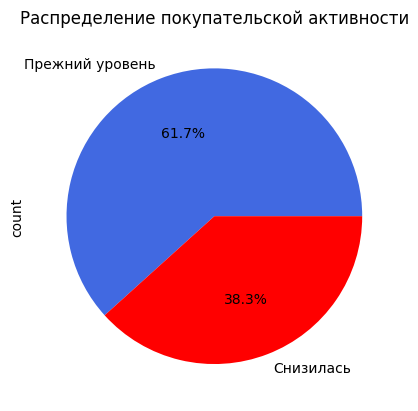

In [23]:
market['Покупательская активность'].value_counts().plot(kind='pie',
                                                        autopct='%1.1f%%',
                                                        grid=True,   
                                                        colors = ['royalblue', 'red'])

plt.title('Распределение покупательской активности')
plt.show()

Почти 40% процентов клиентов попали в категорию Снизилась. С учетом установленной вероятной ошибки в данных, возможно это завышенные показатели.

Посмотрим, есть ли клиенты, которые за прошедшие 3 месяца не совершали покупки.

In [24]:
m_money[m_money['Выручка'] == 0]

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Получаем 3 id, идентичные трем ранее установленным новым покупателям сайта. Следовательно, все покупатели, данные по которым представлены, совершали покупки в указанный период. Удалим данные аномальные значения.

In [25]:
market = market[market['Акционные_покупки'] > 0]
market.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 1 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская активность            1297 non-null   object 
 2   Тип сервиса                          1297 non-null   object 
 3   Разрешить сообщать                   1297 non-null   int64  
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                     

Попробуем визуально оценить, есть ли потенциально закономерности в распределении клиентов на группы Снижение и Текущий уровень покупательской активности.

In [26]:
#разделим данные на 2 датасета
low = market[market['Покупательская активность'] == 'Снизилась']
same = market[market['Покупательская активность'] == 'Прежний уровень']

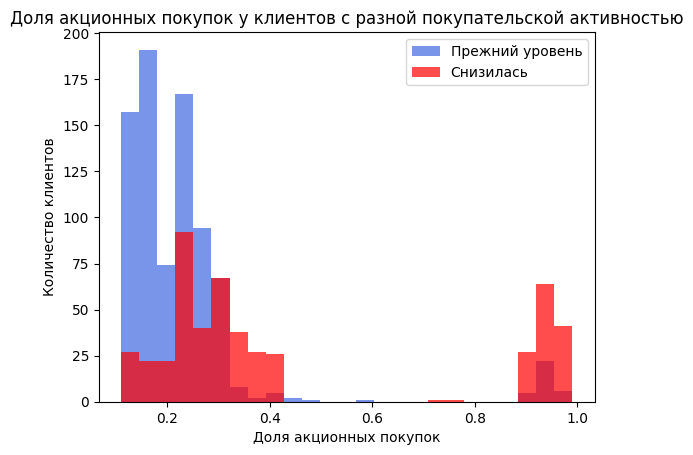

In [27]:
plt.hist(same['Акционные_покупки'], bins = 25, alpha = 0.7, label = 'Прежний уровень', color='royalblue')
plt.hist(low['Акционные_покупки'], bins = 25, alpha = 0.7, label = 'Снизилась', color='red')
plt.title('Доля акционных покупок у клиентов с разной покупательской активностью')
plt.xlabel('Доля акционных покупок')
plt.ylabel('Количество клиентов')
plt.legend(loc='upper right')
plt.show()

Можем отметить, что у покупателей со сниженной активностью доля акционных покупок выше чем у покупателей с прежним уровнем.

Также на столбчатой гисограмме видим два "острова" относительно нормального распределения в диапазонах от 10 до 40% и от 90 до 99%. Оценим графиком "ящик с усами", насколько, согласно нему, правая часть относится к выбросам.

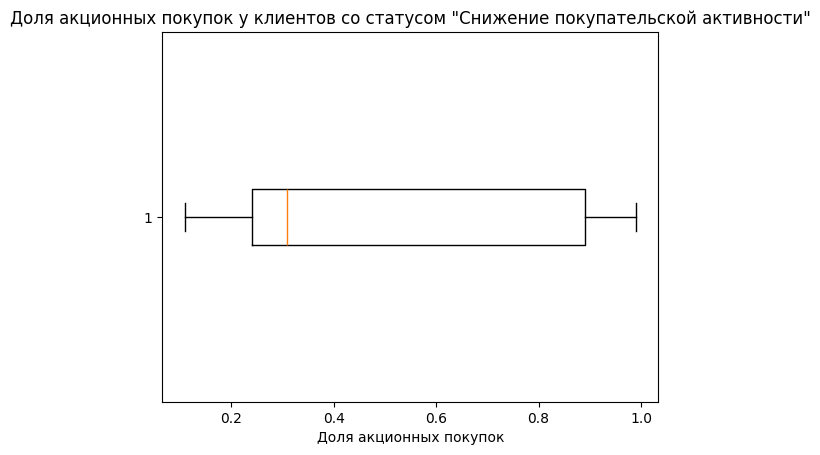

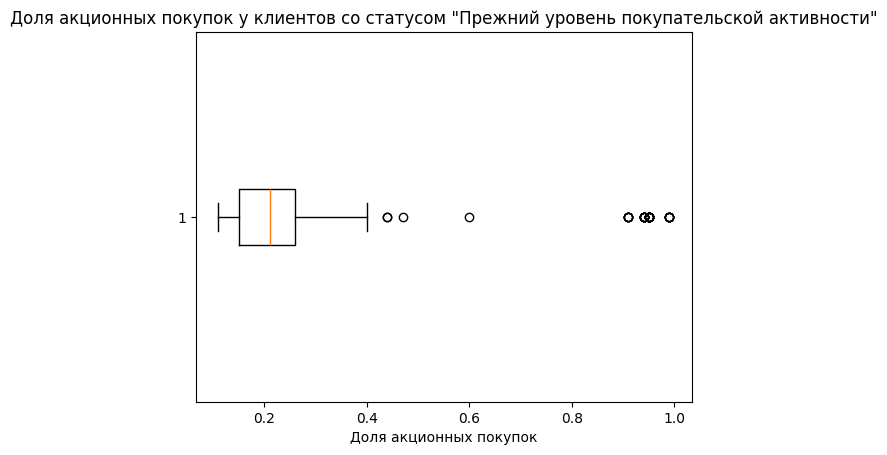

In [28]:
plt.boxplot(
    low['Акционные_покупки'], vert=False
)
plt.title('Доля акционных покупок у клиентов со статусом "Снижение покупательской активности"')
plt.xlabel('Доля акционных покупок')
plt.show()

plt.boxplot(
    same['Акционные_покупки'], vert=False
)
plt.title('Доля акционных покупок у клиентов со статусом "Прежний уровень покупательской активности"')
plt.xlabel('Доля акционных покупок')
plt.show()

Ввиду того, что основной массив данных находится в пределах до 40%, то график относит все значения справа к выбросам. Насколько в целом возможно наличие определенного количества клиентов, которые приобретают товары практически только по акции? Согласно [исследованиям](https://incrussia.ru/news/skidki-aktsii/), существует достаточно большое количество граждан, которые в целом стараются приобретать товары исключительно по акциям. Т.к. нет данных о географии продаж либо иной информации, делающей клиентов менее обезличенными, то ориентируемся на данные в целом по стране. Согласно открытым данным Росстата, уровень бедности снижается (следовательно, все больше людей увеличивают свою покупательскую способность), однако при этом реальные доходы снижаются (с учетом инфляции и высокого роста цен). Следовательно, можем предположить, что доля клиентов, которые значительно большую часть своей корзины составляют практически исключительно из акционных товаров, растет.

Исходя из этого, делаем вывод, что данные, вероятно, корректны. Т.к. необходимо разработать модель, которая будет более объективно предсказывать возможность снижения покупательской активности, данные с менее типичным распределением сохраняем для большей репрезентативности.  

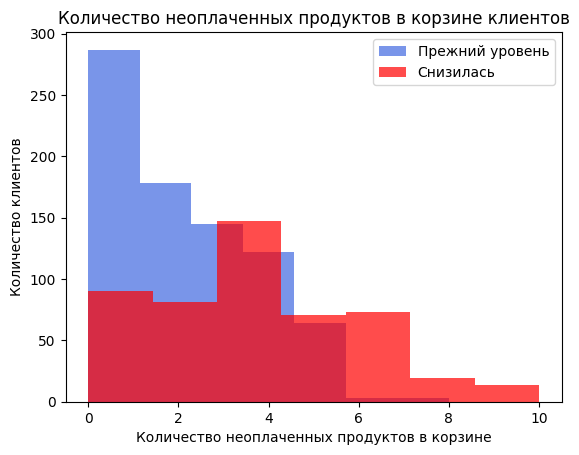

In [29]:
plt.hist(same['Неоплаченные_продукты_штук_квартал'], bins = 7, alpha = 0.7, label = 'Прежний уровень', color='royalblue')
plt.hist(low['Неоплаченные_продукты_штук_квартал'], bins = 7, alpha = 0.7, label = 'Снизилась', color='red')
plt.title('Количество неоплаченных продуктов в корзине клиентов')
plt.xlabel('Количество неоплаченных продуктов в корзине')
plt.ylabel('Количество клиентов')
plt.legend(loc='upper right')
plt.show()

В данном случае видим уже куда более явное деление по покупательскому поведению. У клиентов с прежним уровнем покупательской активности количество неоплаченных товаров в корзине отсутствует или минимально,  в то время как при снижении активности этот показатель растет.

С учетом графика выше, можем предположить, что это связано с отсутствием акций на интересующий покупателей товар. Они как бы откладывают его на сайте и ожидают снижения цены. Если это так, то, вероятно, у таких покупателей должно быть и меньше количество посещенных страниц (т.к. их интересуют определенные товары, уже отложенные в корзину).

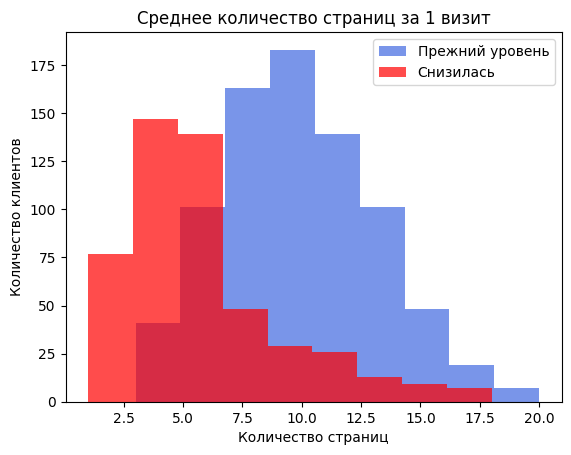

In [30]:
plt.hist(same['Страниц_за_визит'], bins = 9, alpha = 0.7, label = 'Прежний уровень', color='royalblue')
plt.hist(low['Страниц_за_визит'], bins = 9, alpha = 0.7, label = 'Снизилась', color='red')
plt.title('Среднее количество страниц за 1 визит')
plt.xlabel('Количество страниц')
plt.ylabel('Количество клиентов')
plt.legend(loc='upper right')
plt.show()

Действительно, у таких покупателей в среднем просмотрено заметно меньше страниц сайта чем у второй группы. Соответственно, не можем отвергнуть ранее выдвинутую гипотезу о взаимосвязи отсутствия акций на интересующие покупателей товары и снижением их активности.

Может ли дело быть в отсутствии достаточного количества маркетинговых коммуникаций?

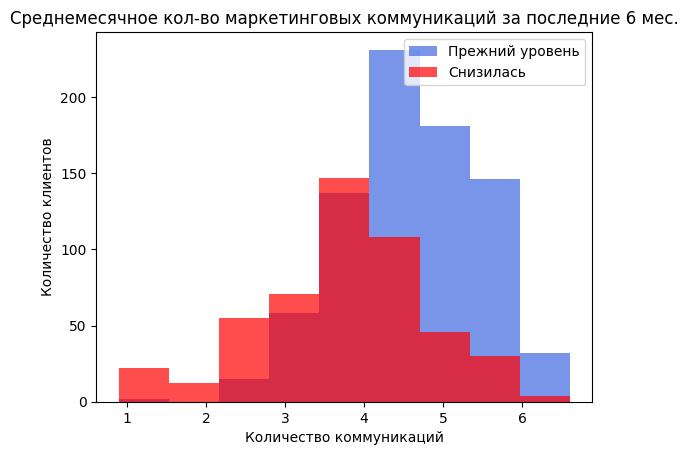

In [31]:
plt.hist(same['Маркет_актив_6_мес'], bins = 9, alpha = 0.7, label = 'Прежний уровень', color='royalblue')
plt.hist(low['Маркет_актив_6_мес'], bins = 9, alpha = 0.7, label = 'Снизилась', color='red')
plt.title('Среднемесячное кол-во маркетинговых коммуникаций за последние 6 мес.')
plt.xlabel('Количество коммуникаций')
plt.ylabel('Количество клиентов')
plt.legend(loc='upper right')

plt.show()

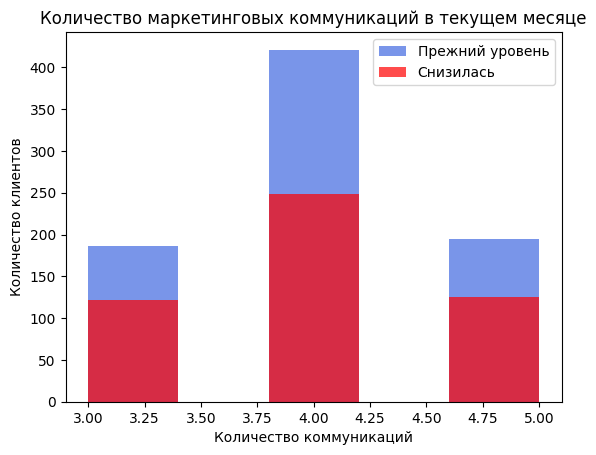

In [32]:
plt.hist(same['Маркет_актив_тек_мес'], bins = 5, alpha = 0.7, label = 'Прежний уровень', color='royalblue')
plt.hist(low['Маркет_актив_тек_мес'], bins = 5, alpha = 0.7, label = 'Снизилась', color='red')
plt.title('Количество маркетинговых коммуникаций в текущем месяце')
plt.xlabel('Количество коммуникаций')
plt.ylabel('Количество клиентов')
plt.legend(loc='upper right')
plt.show()

В среднем, такие клиенты действительно получили меньше маркетинговых предложений чем остальные клиенты. Однако в текущем месяце соотношение примерно равное. 

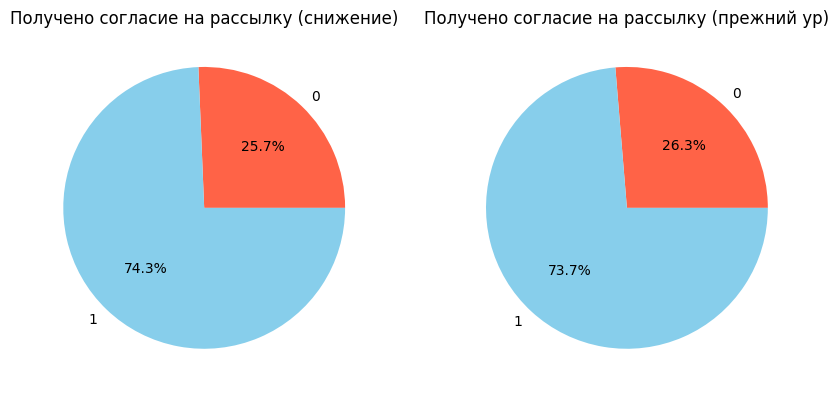

In [33]:
low_gb_m = low.groupby('Разрешить сообщать')['Разрешить сообщать'].count()
same_gb_m = same.groupby('Разрешить сообщать')['Разрешить сообщать'].count()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].pie(low_gb_m, autopct='%1.1f%%', labels=low_gb_m.index, colors=['tomato','skyblue'])
axes[0].set_title('Получено согласие на рассылку (снижение)')

axes[1].pie(same_gb_m, autopct='%1.1f%%', labels=same_gb_m.index, colors=['tomato','skyblue'])
axes[1].set_title('Получено согласие на рассылку (прежний ур)')


plt.show()

Но это не связано с тем, что у сайта просто отсутствует согласие клиента на такие рассылки. Можем предположить, что сниженное количество обусловлено отсутствием такого разрешения ранее. Например, клиент решил не отслеживать появление акций на интересующий его товар и дал согласие на рассылку, в связи с чем в текущем периоде разница между категориями не столь существенна. Либо можем предположить, что на сайте была введена возможность подключить рассылки на более узкие категории товаров (а, например, не в целом по всему каталогу). Однако ввиду отсутствия информации об этом опровергнуть или нет гипотезу мы не можем.

В таком случае, рассмотрим, нет ли взаимосвязи с количеством технических сбоев на сайте. Т.к. возможно это стало причиной снижения активности клиентов.

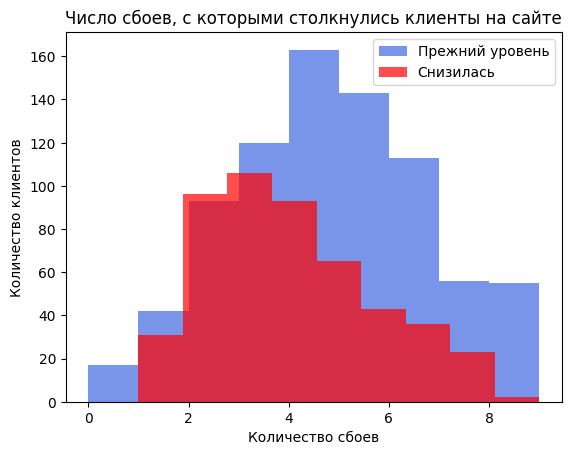

In [34]:
plt.hist(same['Ошибка_сервиса'], bins = 9, alpha = 0.7, label = 'Прежний уровень', color='royalblue')
plt.hist(low['Ошибка_сервиса'], bins = 9, alpha = 0.7, label = 'Снизилась', color='red')
plt.title('Число сбоев, с которыми столкнулись клиенты на сайте')
plt.xlabel('Количество сбоев')
plt.ylabel('Количество клиентов')
plt.legend(loc='upper right')
plt.show()

Видим, что в среднем такие покупатели реже сталкиваются с ошибками. Однако, с поправкой на количество посещенных страниц (как было отмечено ранее, они посещяют в среднем куда меньше страниц сайта чемм покупатели с прежним уровнем активности), соотношение примерно равное. Следовательно, вряд ли техническое состояние сайта является причиной, а вероятнее дело именно в акциях на товары.

В таком случае, рассмотрим, как в целом распределяются категории у клиентов.

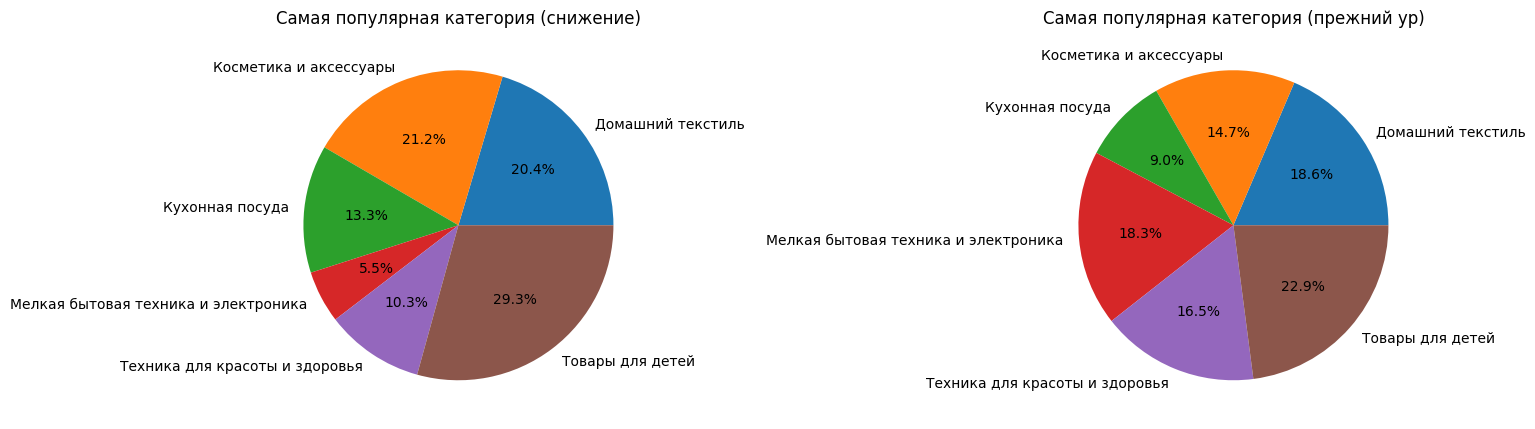

In [35]:
low_gb = low.groupby('Популярная_категория')['Популярная_категория'].count()
same_gb = same.groupby('Популярная_категория')['Популярная_категория'].count()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
plt.subplots_adjust(wspace=1)

axes[0].pie(low_gb, autopct='%1.1f%%', labels=low_gb.index)
axes[0].set_title('Самая популярная категория (снижение)')

axes[1].pie(same_gb, autopct='%1.1f%%', labels=same_gb.index)
axes[1].set_title('Самая популярная категория (прежний ур)')


plt.show()

Домашний текстиль и товары для детей достаточно схожи по объему интереса (~50 и 40 процентов соответственно). Отметим значительную разницу в категориях Мелкая бытовая техника и электроника (данная категория почти в 3,5 раза больше у покупателей с прежним уровнем активности) и Кухонная посуда. В целом можем отметить, что у покупателей с прежним уровнем распределение немного более равномерное чем у покупателей со сниженным. А категория Мелкой бытовой техники вообще наименее представлена на графике слева.

Ввиду ранее выдвинутой гипотезы о взаимосвязи с покупательским поведением и наличием акций, можем предположить, что либо на сайте цены в категории Мелкой бытовой техники выше рынка и/или на них не распространяются акции (в связи с чем таким покупателям изначально невыгодно отслеживать товары на данном сайте, поэтому они до регистрации и заказов уходят к конкрентам), либо же такая категория клиентов в целом меньше/реже закупает товары данной категории (онлайн или в общем).

Можем предположить, что приверженность клиента определенной категории возможно тоже может оказать влияние и потенциально привести к снижению покупательской активности в дальнейшем.

**Предварительно подведем итоги анализа**:
- Предварительно выявлены 3 возможно аномальных клиента, ошибочно попавших в категорию Снижения активности. По итогу слияния датасетов необходимо проверить, являеются ли эти 3 пользователя аномальными значениями или же действительно есть закономерность (т.е. система присваивает статус Прежний уровень пользователем с таким же объемом покупок, а в остальных ставит статус Снизилась).
- На основе графиков можем выдвинуть гипотезу о том, что категория клиентов с высокой долей акционных товаров в общем числе покупок более склона к снижению уровня активности. Возможно это связано с отсутствием акций на интересующие товары.
- В пользу этой гипотезы говорит большее (чем у остальных пользователей) число товаров в корзине, меньшее количество посещенных страниц за 1 визит.
- В таком случае меньшее количество маркетинговых коммуникаций могло привести к соответствующему снижению уровня активности. С учетом того, что в текущем месяце показатели мало отличаются от остальных пользователей, возможно ранее отсутствовало разрешение на получение сообщений от таких клиентов и/или не было подходящих для них вариантов.

## Объединение датасетов

Объединим данные из датасетов market, m_money и m_time в единый датафрейм для дальнейшего моделирования.

В основном датасете market данные по каждому клиенту представлены в рамках 1 строки, в то время как в m_money и m_time данные по 1 пользователю указаны в 3 и 2 строках соответственно. Поэтому в итоговом датафрейме учтем это и данные по каждому периоду укажем отдельным столбцом.

In [36]:
data = pd.merge(market, m_money[m_money['Период'] == 'текущий_месяц'][['id','Выручка']], on='id', how='left')
data = pd.merge(data, m_money[m_money['Период'] == 'предыдущий_месяц'][['id','Выручка']], on='id', how='left', suffixes=('_текущий_месяц', '_предыдущий_месяц'))
data = pd.merge(data, m_money[m_money['Период'] == 'препредыдущий_месяц'][['id','Выручка']], on='id', how='left')
data.rename(columns={'Выручка': 'Выручка_препредыдущий_месяц'}, inplace=True)

data

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц
0,215349,Снизилась,премиум,1,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0
1,215350,Снизилась,стандарт,0,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0
2,215351,Снизилась,стандарт,1,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0
3,215352,Снизилась,стандарт,0,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0
4,215353,Снизилась,стандарт,1,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,Прежний уровень,стандарт,1,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4741.7,3664.0,4704.0
1293,216644,Прежний уровень,стандарт,0,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5353.0,4729.0,5299.0
1294,216645,Прежний уровень,стандарт,1,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5139.2,5160.0,5334.0
1295,216646,Прежний уровень,стандарт,1,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,5224.6,4923.0,4725.0


In [37]:
#Проверим, что данные не были утеряны
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская активность            1297 non-null   object 
 2   Тип сервиса                          1297 non-null   object 
 3   Разрешить сообщать                   1297 non-null   int64  
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

Пропусков нет, данные объединены корректно. 

Сразу отметим, что в последних столбцах видим, что у клиентов стоит Прежний уровень покупательской активности, хотя выручка явно снизилась в текущем периоде. Исходя из этого, делаем вывод, что присвоение статуса зависит от иных показетелей. Впрочем, это не отвечает на вопрос, почему у 3 ранее удаленных покупателей был проставлен такой статус. Необходимо уточнение по данному вопросу от заказчика.

In [38]:
data.describe()

,id,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,215998.986893,0.739399,4.254433,4.009252,602.993832,0.320547,3.267540,2.841172,4.184271,8.186584,5316.449268,4948.339630,4836.367772
std,374.578554,0.439132,1.015618,0.696048,249.101456,0.249657,1.354623,1.973451,1.950973,3.977061,2942.469139,701.228571,333.438742
min,215349.000000,0.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,2758.700000,2890.000000,4098.000000
25%,215675.000000,0.000000,3.700000,4.000000,410.000000,0.170000,2.000000,1.000000,3.000000,5.000000,4706.600000,4498.500000,4585.000000
50%,215999.000000,1.000000,4.200000,4.000000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000,5180.300000,5005.500000,4812.000000
75%,216323.000000,1.000000,4.900000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000,5761.300000,5409.000000,5055.000000
max,216647.000000,1.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,106862.200000,6869.500000,5663.000000


Отметим аномально высокое максимальное значение в столбце Выручка_текущий_месяц. Рассмотрим отдельно.

In [39]:
data[data['Выручка_текущий_месяц'] > 80000]

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц
29,215380,Снизилась,премиум,0,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7,106862.2,6077.0,5051.0


Только один клиент с крайне высокими продажами за текщий период,в т.ч значительно выше предыдущего периода, статус по активности при этом - Снизилась. Т.к. такая аномалия может привести к некорректному обучению модели, удалим ее.

In [40]:
data = data[data['Выручка_текущий_месяц'] < 80000]

In [41]:
#Теперь добавим данные о времени, проведенном на сайте
data = pd.merge(data, m_time[m_time['Период'] == 'текущий_месяц'][['id','минут']], on='id', how='left')
data = pd.merge(data,  m_time[m_time['Период'] == 'предыдущий_месяц'][['id','минут']], on='id', how='left', suffixes=('_текущий_месяц', '_предыдущий_месяц'))

data

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
0,215349,Снизилась,премиум,1,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
1,215350,Снизилась,стандарт,0,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
2,215351,Снизилась,стандарт,1,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
3,215352,Снизилась,стандарт,0,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
4,215353,Снизилась,стандарт,1,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,216643,Прежний уровень,стандарт,1,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4741.7,3664.0,4704.0,7,14
1292,216644,Прежний уровень,стандарт,0,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5353.0,4729.0,5299.0,11,12
1293,216645,Прежний уровень,стандарт,1,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5139.2,5160.0,5334.0,18,12
1294,216646,Прежний уровень,стандарт,1,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,5224.6,4923.0,4725.0,7,18


In [42]:
#Проверим, что данные не были утеряны
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Покупательская активность            1296 non-null   object 
 2   Тип сервиса                          1296 non-null   object 
 3   Разрешить сообщать                   1296 non-null   int64  
 4   Маркет_актив_6_мес                   1296 non-null   float64
 5   Маркет_актив_тек_мес                 1296 non-null   int64  
 6   Длительность                         1296 non-null   int64  
 7   Акционные_покупки                    1296 non-null   float64
 8   Популярная_категория                 1296 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  Ошибка_сервиса                

Пропусков в данных нет. Данные готовы к корреляционному анализу и дальнейшему обучению модели.

## Корреляционный анализ

Построим матрицу корреляции для количественных признаков итогового датафрейма и рассмотрим ее детальнее.

<Axes: >

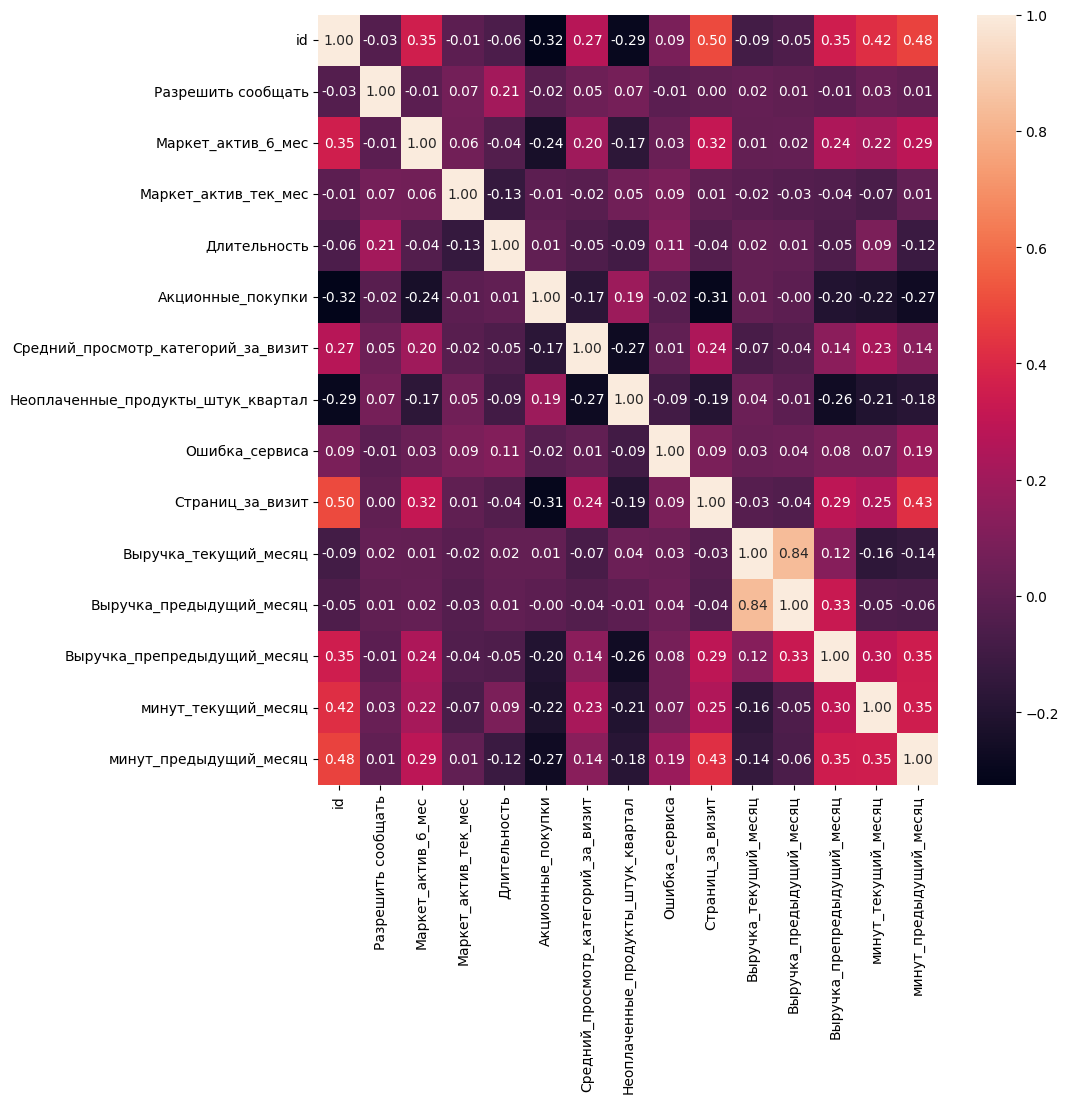

In [43]:
plt.figure(figsize = (10,10))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt='.2f')

Рассмотрим наиболее интересные для нас результаты:
- id:
    - Неожиданно выявлена корреляция между номером id и сразу несколькими показателями (Страниц за визит, Выручка препредыдущий месяц, минут текущий и предыдущий месяцы, Маркетинговая активность за последние 6 мес). Исходя из того, как данные представлены в датафрейме (т.е. id идут последовательно друг за другом в порядке возрастания), можем предположить, что чем позже клиент зарегистрировался на сайте, тем больший номер id у него будет. Следовательно, можем выдвинуть гипотезу, что более новые клиенты в среднем больше проводят времени на сайте, посещают больше страниц. Однако корреляции с выручкой за текущий и предыдущий месяц нет или она носит нелинейных характер(в отличие от выручки за препредыдущий месяц). 
    - При этом отметим обратную зависимость у объема акционных товаров в общих покупках клиента и количестве неоплаченных товаров в корзине. 
     
     
- Акционные покупки:
    - Ранее выдвигали гипотезу относительно связи объема акционных покупок и потенциальном снижением активности клиентов, а также отмечали, что такие клиенты меньше посещают страниц на сайте и в целом меньше времени проводят на сайте. И видим по матрице, что действительно, чем выше показатель доли Акционных покупок, тем ниже показатели Минут за текущий и предыдущий периоды, а также Страниц за визит. 
    - Однако отметим отсутствие линейной зависимости между долей акционных покупок и объемом выручки за текущий и предыдущий периоды.
    
    
- Неоплаченные продукты:
    - Видим, что зависимости очень схожи с теми, которые наблюдаются по показателю Акционные покупки, хотя между двумя показателями корреляция небольшая. Однако это также говорит в пользу ранее выдвинутой гипотезы.
    
    
- Страниц за визит:
    - Достаточно ожидаемо видим взаимосвязь между количеством просмотренных страниц за визит и временем на сайте. 
    - При этом отметим корреляцию со средним количеством маркетинговых коммуникаций за полгода и ее отсутствие с активностями за текущий месяц. Возможно это связано с изменениями в маркетинговых мероприятиях или же с большой долей клиентов со снизившейся активностью.


- Выручка:
    - Интересно наличие зависимости между выручкой и временем на сайте. Можем предположить, что это может быть связано с тем, что клиенты в таком случае заказывают больше товаров. Либо же это возникает из-за того, что выручка от клиентов с небольшой долей акционных товаров выше, а, как было установлено ранее, такие клиенты в среднем больше времени проводят на сайте.


- Ошибка сервиса:
    - Наблюдаем, по сути, отсутствие линейной зависимости между количеством ошибок, с которыми сталкивается клиент на сайте, и другими показателями в датафрейме, хотя было бы ожидаемо увидеть взаимосвязь со временем, проведенным на сайте. Возможно это обусловлено разницей в часах активности клиентов и изменениями на сайте, приводящим к сбоям. 
    
Мультиколлинеарности не наблюдаем.

## Пайплайны

Разбиваем данные на тренировочную и тестовую выборки.

In [44]:
X = data.drop(['Покупательская активность', 'id'], axis=1)
y = data['Покупательская активность']
RANDOM_STATE = 50


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    stratify=y
)

Для оптимизации дальнейшей работы с моделями подготовим пайплайны.

Для кодирования категориальных признаков используем 2 кодировщика: OneHotEncoder и OrdinalEncoder. Для масштабирования количественных признаков используем 2 скейлера: StandardScaler, MinMaxScaler

Введём обозначения для типов исходных данных в зависимости от типа используемого кодировщика:

In [45]:
data.head(2)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
0,215349,Снизилась,премиум,1,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
1,215350,Снизилась,стандарт,0,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8


In [46]:
ohe_columns = ['Популярная_категория']
ord_columns = ['Тип сервиса']

In [47]:
num_columns = [
    'Разрешить сообщать', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес',
    'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит',
    'Выручка_текущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц',
    'минут_текущий_месяц', 'минут_предыдущий_месяц'
]

На текущий момент в данных нет пропусков, однако возможно, что они могут появиться в новых данных в дальнейшем, учтем это при формировании пайплайна с помощью SimpleImputer.

In [48]:
data['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [49]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ])

ord_pipe = Pipeline(
    [
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories = [['премиум', 'стандарт']])),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
], 
   remainder='passthrough')


pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])

За основу берем 4 модели: метод k-ближайших соседей(KNeighborsClassifier), дерево решений (DecisionTreeClassifier), логистическая регрессия (LogisticRegression) и классификация опорных векторов (SVC). Для каждой подбираем, по возможности, оптимальные гиперпараметры.

За основу проверки качества работы модели возьмем метрику roc-auc. В данном случае мы вынужденно работаем с несбалансированными по количеству данными (как отмечали ранее, клиентов с Прежним уровнем активности больше). 

In [50]:
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_leaf': range(1,10),
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    }
]

In [51]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [52]:
randomized_search.fit(X_train, y_train)

print('Метрика roc_auc для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Метрика roc_auc для лучшей модели:
 0.8701857679994044

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  

По итогу оценки 4 моделей, лучший результат дала модель дерева решений (DecisionTreeClassifier) с максимальной глубиной 11, количество объектов на 1 "листе" 7, а минимальное количество объектов на узле для разделения на классы - 9. Метрика roc_auc на тренировочных данных составила 87%, относительно высокий показатель.

Фиксируем итоговую модель в финальном пайплайне.

In [53]:
pipe_final_2 = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(max_depth=11, min_samples_leaf=7,
                                          min_samples_split=9, random_state=RANDOM_STATE))
    ])

Оценим работу модели по метрике roc-auc при кросс-валидации.

In [54]:
result = cross_val_score(pipe_final_2, X_train, y_train, cv=10, scoring='roc_auc')

pipe_final_2.fit(X_train, y_train)
y_proba = pipe_final_2.predict_proba(X_test)[:,1]

print(f"[Кросс-валидация] Все значения ROC-AUC: {[round(x,2) for x in result]}")
print(f"[Кросс-валидация] Среднее значение ROC-AUC: {result.mean():.2f}")
print("[Тестовая выборка] ROC-AUC: 0.87")
print(f"[Тренировочная выборка] ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")

[Кросс-валидация] Все значения ROC-AUC: [0.92, 0.82, 0.87, 0.86, 0.9, 0.83, 0.9, 0.83, 0.84, 0.84]
[Кросс-валидация] Среднее значение ROC-AUC: 0.86
[Тестовая выборка] ROC-AUC: 0.87
[Тренировочная выборка] ROC-AUC: 0.85


Разница в тестовой и тренировочной выборках небольшая, однако все равно отмечаем снижение точности модели на тренировочных данных.

При кросс-валидации значение падает. Кроме того, отметим, что разброс метрики также выходит значительным (от 0.82 до 0.92).

Значит, на высокий результат появлияло то, какие именно значения попали в выборку. Рассмотрим, как распределяются показатели важности признаков. Возможно это позволит повысить точность модели.

## Анализ важности признаков

Оценим важность признаков для лучшей модели, построим график важности и рассмотрим его детально.

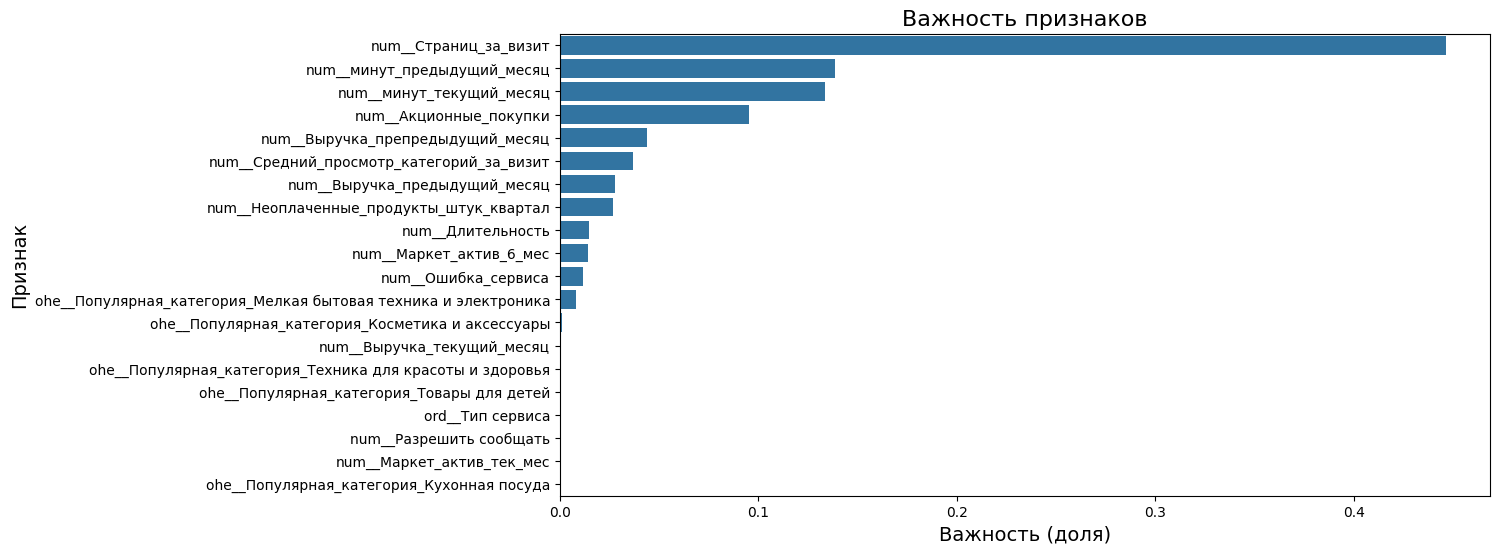

In [55]:
X_train_prep = data_preprocessor.fit_transform(X_train)
X_test_prep = data_preprocessor.transform(X_test)

model = DecisionTreeClassifier(max_depth=11, min_samples_leaf=7,
                               min_samples_split=9, random_state=RANDOM_STATE)
model.fit(X_train_prep, y_train)

feature_importances = pd.DataFrame(
    {
        'Feature': data_preprocessor.get_feature_names_out(),
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importances
)


ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)

plt.show()

Отметим:
- Малозначимые признаки для модели: тип сервиса, длительность (т.е. количество дней с момента регистрации на сайте). Также модель не сочла значимыми почти все категории товаров, кроме Мелкой быовой техники и электроники. Ранее также отмечали большую разницу в количестве людей с данной любимой категорией среди покупателей с прежним и снизившимся уровнями покупательской активности. 
- Неожиданно, что выручка за препредыдущий месяц оказалась более значима для модели, чем за предыдущий. Выручку за текущий месяц модель и вовсе не учитывает.
- Наиболее значимые признаки: количество просмотренных страниц за визит и количествено минут, проведенное на сайте, а также доля акционных покупок. При этом именно количество сраниц за визит является наиболее решающим фактором, важность практически 0.5.

Как можно использовать эти наблюдения при моделировании и принятии бизнес-решений: 
- Можем предположить, что ключевым фактором является не столько привлечение клиента зайти на сайт, сколько удержать его внимание и стимулировать его более длительное время потратить на изучение ассортимента. Согласно полученным данным, это может стать ключевым фактором при принятии решении о покупке.
- Однако возможно это связано с неоптимальной работой алогоритмов поиска и предложения товаров на сайте, в следствие чего покупателю необходимо больше времени на принятие решения. 
    - Если не отвергаем данную гипотезу, то это может приводить к оттоку новых покупателей. Например, они были привлечены рекламной/действующими клиентами на определенные акционные товары, соответственно, имели достаточно конкретный запрос, а после их активность стала снижаться, т.к. акций на этот же товар уже нет, а алгоритмы не могут предложить им альтернативы и/или иных, интересных для них, товаров. 
    - Это соотносится с имеющимися в датафрейме данными, т.к. мы могли отметить большую долю клиентов с долей акционных товаров более 98% и сниженной активностью. 
    - В таком случае рекомендованно провести оценку "дружелюбности" интерфейса и алгоритмов поиска сайта, насколько они отвечают запросам клиента (например, силами сотрудников или же провести опрос для клиентов на сайте).
    - Если гипотеза представляется маловероятной для бизнеса, то для ее опровержения возможно стоит добавить в датафрейм информацию об источнике привлечения клиента (например, реферальные ссылки) или же соотнести маркетинговые активности (для широкого круга лиц, т.е. не только для действующих клиентов), указанные в них акционные товары и долю таких товаров в первой покупке клиента. И соотнести это с текущей покупательской активностью.
    
- Не смотря на ранее отмеченное отсутствие разницы в количестве ошибок, с которыми сталкиваются клиенты разных групп, модель сочла такие данные значимыми при оценке. Вероятно, в данном случае это также связано с разницей во времени, которое покупатели проводят на сайте. Соответственно, в дальнейшем при корректировке модели, возможно стоит пересмотреть значимость некоторых данных, на которых модель обучается и строит далее прогнозы.
    - Так, например, данные о количестве ошибок можно в дальнейшем исключить. А данные о времени на сайте сократить, т.е. вместо данных о минутах, количестве просмотренных страниц и категорий, ввести обобщающее значение (например, страниц в минуту) или просто оставить только одно значение, дабы модель смогла сфокусироваться и на других данных,что потенциально может повысить точность модели при работе с разными клиентами.

- Тип сервиса и вовсе, насколько можем судить, не оказывает существенного влияния на покупательскую активность, как минимум в разрезе имеющихся данных. Соответственно, вероятно, в текущем виде он или не предоставляет достаточного количества преимуществ для постоянных покупателей(т.е. не работает на удержание) и носит номинальный характер, или же не влияет на объем покупок в целом (например, касается сопутствующих операций, такие как визуальные изменения сайта (ночной/дневной режим), псевдо закрытые распродажи и прочее). Следовательно, необходимо либо переработать значимость статусов, либо же не учитывать их в анализе.

## Сегментация покупателей

Отметим достаточно большой "разбег" между минимальным и максимальным значением (0.86 и 7.43), однако в целом данные нормально распределены с относительно небольшим стандартным отклонением, среднее и медианное значения достаточно близки. 

В таком случае можем разделить клиентов на 3 группы:
- Normal, диапазон от 2.98 до 5.01 (среднее ± стандартное отклонение): наиболее крупная группа (~68%), основная часть клиентов. Такие покупатели не тратят много (в сравнении с группой High), однако за счет числа и обычно большей постоянности зачастую приносят основную прибыль компании. Основная целевая аудитория.
- Low, диапазон от 0.86 до 2.97 (от минимума до границы Normal): менее представленная группа (~16%). Зачастую в данную категорию попадают новые клиенты, нецелевая аудитория (стали покупателями из-за акций на определенные товары и/или из-за более выгодной цены на какие-то конкретные товары). Зачастую такие клиенты покупают редко, небольшими объемами (или штучно), легче могут уйти к конкурентам. При грамотной стратегии бизнеса со временем переходят в категорию Normal. Также в данную категорию попадают "уходящие" клиенты, т.е. те, кто по каким то причинам стали покупать меньше.
- High, диапазон от 5.02 до 7.43 (от границы Normal до максимума): вторая менее представленная группа (~16%). Покупатели, которые берут сразу большие объемы и/или дорогие товары. Зачастую это бизнес, который осуществляет закупки для своей деятельности (не обязательно перепродажа). Обычно такие клиенты покупают редко, им важно персональное внимание, индивидуальные предложения, ценят сопутствующие услуги (сервис, доставка и т.д.).

При необходимости возможно последние две категории разделить еще надвое, отдельно выделив Super-Low (зачастую, "случайные" клиенты, которые единоразово или крайне редко что-то приобретают, зачастую штучно и ввиду наличия выгодной акции, сложно удержать) и Super-High (сверхредкие клиенты, тратящие значительные суммы, чаще всего крупные компании, проводящие закупки с оформлением сопутствующих документов; ввиду бюрократических нюансов приобретают что-то оцень редко, но в крайне больших объемах, соответствено, требуют сопровождения в процессе, что не всегда выгодно бизнесу в долгосрочной перспективе). На текущем этапе не будем этого делать. Добавим обозначение категорий.

<Axes: >

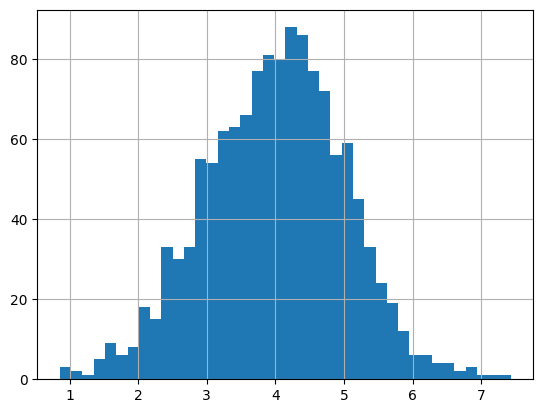

In [56]:
money['Прибыль'].hist(bins=40)

In [57]:
def cat_profit(profit):
    if profit <= 2.97:
        return 'Low'
    elif profit >= 5.02:
        return 'High'
    return 'Normal'

In [58]:
money['Группа'] = money['Прибыль'].apply(cat_profit)

Объединим данные с остальной информацией о клиентах.

In [59]:
data_m = pd.merge(data, money, on='id', how='left')

data_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Покупательская активность            1296 non-null   object 
 2   Тип сервиса                          1296 non-null   object 
 3   Разрешить сообщать                   1296 non-null   int64  
 4   Маркет_актив_6_мес                   1296 non-null   float64
 5   Маркет_актив_тек_мес                 1296 non-null   int64  
 6   Длительность                         1296 non-null   int64  
 7   Акционные_покупки                    1296 non-null   float64
 8   Популярная_категория                 1296 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  Ошибка_сервиса                

Рассмотрение категории Normal приведет к получению схожих с исходными результатов, т.к. по умолчанию данная категория наиболее представлена в исходной выборке и, соответственно, оказывает наибольшее влияние. Поэтому рассмотрим детальнее группу покупателей Low, т.е. новых, потенциальных и уходящих клиентов.

По итогам моделирования, можем выделить ключевые показатели, которые стоит оценить в текущих данных:
- Длительность пребывания на сайте (количество проведенных минут и просмотренных страниц за визит).
- Доля акционных покупок.

In [60]:
#Отделим данные по категории для удобства
low_p = data_m[data_m['Группа'] == 'Low']
low_p = low_p.drop('id', axis=1)

#Рассмотрим общее распределение данных по группе
low_p.describe()

,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,Прибыль
count,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.00000,207.000000,207.000000,207.000000
mean,0.714976,4.294203,4.038647,599.309179,0.349130,3.318841,2.695652,4.217391,8.473430,5306.242029,5000.038647,4835.36715,12.884058,13.198068,2.434686
std,0.452520,1.029358,0.723029,254.165570,0.282256,1.327375,2.016709,1.912170,3.915121,829.339836,726.373972,321.30976,4.315932,3.765505,0.454471
min,0.000000,1.400000,3.000000,125.000000,0.110000,1.000000,0.000000,1.000000,1.000000,3267.000000,2890.000000,4128.00000,4.000000,5.000000,0.860000
25%,0.000000,3.800000,4.000000,400.000000,0.165000,2.000000,1.000000,3.000000,5.500000,4789.400000,4587.500000,4603.00000,10.000000,10.000000,2.185000
50%,1.000000,4.200000,4.000000,609.000000,0.240000,3.000000,2.000000,4.000000,8.000000,5243.700000,5068.500000,4795.00000,13.000000,13.000000,2.530000
75%,1.000000,5.100000,5.000000,801.500000,0.330000,4.000000,4.000000,5.500000,11.000000,5751.550000,5498.000000,5053.00000,16.000000,16.000000,2.805000
max,1.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,19.000000,7370.600000,6809.000000,5638.00000,23.000000,22.000000,2.970000


Видим схожую ситуацию с данными по всем клиентам, что свидетельствует о том, что исходные данные собраны так, чтобы клиенты разных сегментов попали в итоговую выборку.

Отметим, что эти данные также весьма схожи с теми, что имеем в исходных. Однако итоговая прибыль от этих клиентов низкая.

Поэтому отдельно рассчитаем рентабельность продаж и рассмотрим распределение данного показателя. Т.к. данные по выручке представлены за 3 периода, а по прибыли - среднее значение, то рассчитаем среднее по выручке самостоятельно. Кроме того, отметим значительную разницу в указанных цифрах в столбцах (тысячи в выручке и единицы в прибыли). Т.к. конкретизирующей информации в описании данных нет, предположим, исходя из нормы рентабельности (10-30%) с поправкой на общее распределение данных, что для уравнивания показатели выручки необходимо сократить до десятков.

In [61]:
low_p['ROS'] = low_p['Прибыль']/((low_p['Выручка_текущий_месяц']+low_p['Выручка_предыдущий_месяц']+low_p['Выручка_препредыдущий_месяц'])/300)

low_p['ROS'].describe()

count    207.000000
mean       0.048865
std        0.011080
min        0.017627
25%        0.042445
50%        0.049135
75%        0.056136
max        0.081463
Name: ROS, dtype: float64

Теперь можем отметить, что рентабельность продаж таким клиентам крайне низкая (ниже общепринятой в 8-10% и рекомендуемой для маркетплейсов >20%). Можно было бы предположить, что это обусловленно высокой долей акционных покупок, однако ранее могли отметить, что в разрезе группы это не совсем так. Рассмотрим в конктексте распределения по популярным категориям.

Т.к. в данных по доле акционных покупок есть сверхвысокие значения, возьмем медианные значения для большей корректности.

In [62]:
low_p.groupby('Популярная_категория')[['ROS','Акционные_покупки']].median()

,ROS,Акционные_покупки
Популярная_категория,,
Домашний текстиль,0.050961,0.220
Косметика и аксесcуары,0.049369,0.280
Кухонная посуда,0.051480,0.295
Мелкая бытовая техника и электроника,0.044582,0.205
Техника для красоты и здоровья,0.047217,0.240
Товары для детей,0.050284,0.250


И отмечаем, что половина таких клиентов не так много покупает товаров по акции, в среднем только 22-30% их корзины это товары по акции. Однако по всем категориям отмечаем весьма низкую рентабельность. Если проблема не только и не столько в акциях, то, вероятно, дело в покупаемых товарах и/или сопутствующих тратах.

Рассмотрим, в каких же данных есть ключевые отличия в показателях.

In [63]:
low_p.describe() - data_m.describe()

,ROS,id,Акционные_покупки,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Длительность,Маркет_актив_6_мес,Маркет_актив_тек_мес,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Прибыль,Разрешить сообщать,Средний_просмотр_категорий_за_визит,Страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц
count,NaN,NaN,-1089.000000,-1089.000000,-1089.000000,-1089.000000,-1089.000000,-1089.000000,-1089.000000,-1089.000000,-1089.000000,-1089.000000,-1089.000000,-1089.000000,-1089.000000,-1089.000000,-1089.000000
mean,NaN,NaN,0.029061,52.569897,-0.835011,68.145964,-3.658414,0.037799,0.029388,-0.146169,0.032978,-1.563015,-0.024993,0.051094,0.285930,-0.272611,-0.326590
std,NaN,NaN,0.033096,25.576732,-12.204331,-4.978881,4.969747,0.015833,0.026713,0.042636,-0.039549,-0.556728,0.013700,-0.027750,-0.063338,-0.172125,0.094138
min,NaN,NaN,0.000000,0.000000,30.000000,508.300000,4.000000,0.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,-0.005000,89.375000,18.500000,83.350000,-9.500000,0.100000,0.000000,0.000000,0.000000,-1.115000,0.000000,0.000000,0.500000,-0.750000,0.000000
50%,NaN,NaN,0.000000,63.000000,-15.500000,63.750000,2.500000,0.000000,0.000000,-1.000000,0.000000,-1.515000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,0.030000,92.375000,-3.000000,-7.725000,-4.750000,0.200000,1.000000,0.000000,-0.500000,-1.865000,0.000000,0.000000,0.000000,-1.000000,0.000000
max,NaN,NaN,0.000000,-60.500000,-25.000000,-428.800000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.460000,0.000000,0.000000,-1.000000,-1.000000,0.000000


Отметим, что ряд показателей выручки (в особенности квартили) у данной группы даже выше чем по общим данным.

Из чего делаем вывод, что в данном случае первоначальная характеристика группы некорректна. В данном случае можем говорить не о малом объеме продаж, а о низкой их рентабельности. Это свидетельствует о неправильно выбранной стратегии ценообразования, которая требует пересмотра по двум уровням:
- Оценка затрат и итоговой себестоимости продаж товаров, которые приобретают клиенты данной группы. У крупных магазинов обычно есть инструменты воздействия на закупочную стоимость товаров (получение скидок за счет больших объемов и длительности договорных отношений), однако зачастую ключевым оказываются сопутствующие траты, т.е. затраты на сопровождение продажи. Это включает в себя в основном маркетинг и логистику (в т.ч. организация ПВЗ/постоматов). 
    - Маркетинг: стоит проанализировать маркетинговые активности, которые привлекли данную категорию клиентов. Вполне возможно, что высокая стоимость лида обусловлена некорректным форматом рекламы, т.е. форма, месторасположение и время не охватили целевую аудиторию, но смогли привлечь какое-то количесто клиентов. Либо же, если ранее выдвинутая гипотеза о проблемах с пользовательским интерфейсом и/или поиском корректна, то возможно лидов удалось привлечь много, но превратить их в клиентов не удалось, из-за чего, опять же, итоговые затраты на маркетинг себя не окупили. 
    - Логистика: сюда включаем и затраты на перевозку и доставку до клиента (включая зарплату сотрудников на складе, водителей и операторов ПВЗ), а также закладываем определенный процент брака, возникшего в процессе доставки (включая мелкие повреждения, ухудшающие товарный вид). 
- Оценка ценообразования. Для ритейла характерно наличие товаров-крючков, т.е. товаров с ценой ниже (иногда значительно) рынка, цель которых - привлечь клиентов, однако низкую рентабельность таких товаров нивелируют другими товарами (цены на которые могут быть выше рынка, но клиент возьмет их из принципа "чтобы два раза не вставать"). И зачастую такие товары формируют с помощью акций, т.к. в таком случае низкую цену проще обосновать для клиента, эффектнее можно разместить в рекламе и в целом лучше влияет на психику клиентов (как показывают исследования, люди в целом более склонны обращать внимание на акции и больше любят по ним покупать, даже если фактически цена не выгоднаили незначительно ниже рынка). Однако в данном случае отмечаем малую медианную долю акционных товаров в общем объеме покупок. Соответственно, возможно, данные товары давно не переоценивались и сейчас цены находятся на уровне значительно ниже рынка. В данном случае следует действовать осторожно и постепенно, т.к. резкое увеличение цены, вероятнее всего, отпугнет большой объем таких клиентов. Однако при правильном подходе можно привести рентабельность товаров к адекватным значениям и повысить общий объем прибыли, пусть и с потерей небольшого количества клиентов.

Рассмотрим теперь данные по клиентам с точки зрения модели, т.е. учитывая предсказанную вероятность отнесения пользователя к категории "Снижение активности".

<Axes: >

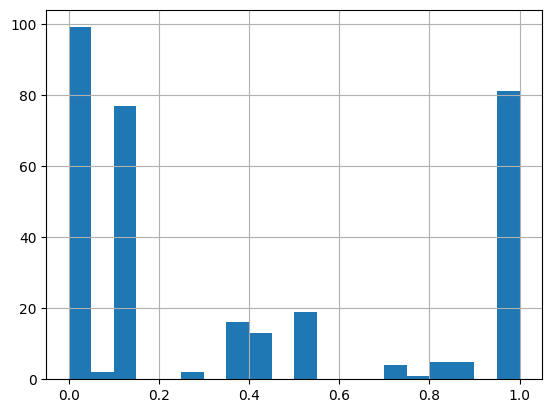

In [64]:
y_info = pd.DataFrame(
    {
        'Факт': y_test,
        'Вероятность': y_proba
    })

y_info['Вероятность'].hist(bins=20)

Распределение в имеющейся выборке явно отличается от нормального. Отметим, что имеются явные пики в 0 и 1, т.е. где модель однозначно присваивает класс, а также примерно в районе 0.15, т.е. объектов с очень низкой вероятностью Снижения.

Т.к. ранее рассматривали клиентов с точки зрения наиболее важного для бизнеса показателя - рентабельности, сделаем это и в данном случае, т.е. добавим в таблицу данные по ROS.

In [65]:
data_m['ROS'] = data_m['Прибыль']/((data_m['Выручка_текущий_месяц']+data_m['Выручка_предыдущий_месяц']+data_m['Выручка_препредыдущий_месяц'])/300)

y_info = y_info.join(data_m)
y_info

,Факт,Вероятность,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,...,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,Прибыль,Группа,ROS
1199,Прежний уровень,0.012500,216551,Прежний уровень,стандарт,0,5.8,5,344,0.13,...,5,13,5163.6,5063.5,5098.0,18,14,3.45,Normal,0.067536
805,Прежний уровень,0.538462,216157,Прежний уровень,стандарт,1,4.0,3,432,0.16,...,2,13,6609.8,5646.5,4685.0,22,17,3.95,Normal,0.069947
144,Снизилась,1.000000,215496,Снизилась,премиум,1,4.0,4,684,0.40,...,2,4,5237.1,5020.0,4896.0,11,11,4.64,Normal,0.091862
188,Снизилась,1.000000,215540,Снизилась,премиум,1,1.4,5,355,0.33,...,5,5,6118.6,5277.5,4826.0,10,9,4.68,Normal,0.086549
782,Прежний уровень,0.000000,216134,Прежний уровень,премиум,1,3.3,5,786,0.16,...,4,11,5347.2,4926.0,4590.0,19,8,1.92,Low,0.038753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,Прежний уровень,0.000000,215849,Прежний уровень,стандарт,1,4.9,4,399,0.25,...,3,5,4563.1,4307.0,4453.0,15,18,3.33,Normal,0.074983
515,Прежний уровень,0.012500,215867,Прежний уровень,стандарт,1,5.4,4,777,0.25,...,6,14,5420.5,5141.0,5313.0,14,13,3.80,Normal,0.071813
396,Прежний уровень,0.111111,215748,Прежний уровень,стандарт,0,4.3,4,534,0.18,...,4,10,5673.2,5083.0,4552.0,13,13,4.11,Normal,0.080545
290,Снизилась,1.000000,215642,Снизилась,премиум,1,3.8,4,962,0.30,...,2,5,5455.0,4857.0,4419.0,7,7,3.48,Normal,0.070871


Теперь построим диаграмму рассеяния

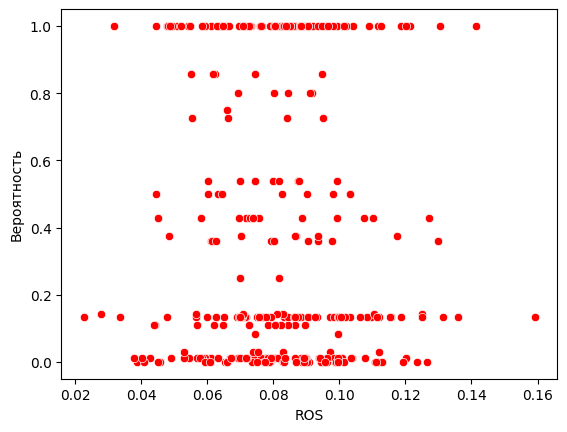

In [66]:
fig, axes = plt.subplots()
sns.scatterplot(y=y_info['Вероятность'],
                x=y_info['ROS'],
                ax=axes, color='red')
plt.show()

Приходим к выводу, что нельзя установить порог вероятности снижения и сохранения уровня активности в зависимости от рентабельности, т.е. и одна, и другая категория, как установили ранее, может приносить разный объем прибыли.

Рассмотрим клиентов с высокой вероятностью снижения активости (>0.7) и низкой рентабельностью (<0.08). Границы нормы рентабельности продаж обозначали ранее (не менее 8%), относительно вероятности снижения: в данном случае ориентируемся на график, где видим достаточно четку границу между 0.7 и 0.6; брать менее 0.7 нерационально, т.к. мы приблизимся к 50%, а если задать границу более 0.8, то упустим и без того небольшое количество предсказанных клиентов. Как уже отмечали ранее, модель более активно присваивала 1 и 0 в качестве вероятности.

In [67]:
ros_low = y_info[(y_info['Вероятность']>0.7)&(y_info['ROS']<0.08)]
ros_low.describe()

,Вероятность,id,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,Прибыль,ROS
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,0.965180,215626.333333,0.733333,3.526667,3.911111,621.911111,0.488667,2.688889,3.955556,3.977778,4.288889,5719.177778,5325.133333,4704.111111,10.066667,10.244444,3.310000,0.063161
std,0.079535,258.504880,0.447214,1.154517,0.733058,232.485955,0.283450,1.258105,2.305680,1.827677,1.841716,901.591851,741.701303,251.142500,2.887276,2.122986,0.635284,0.010770
min,0.727273,215367.000000,0.000000,1.400000,3.000000,186.000000,0.170000,1.000000,1.000000,1.000000,1.000000,3412.500000,3432.000000,4128.000000,4.000000,6.000000,1.480000,0.031875
25%,1.000000,215470.000000,0.000000,3.000000,3.000000,467.000000,0.300000,2.000000,2.000000,3.000000,3.000000,5171.100000,4911.000000,4567.000000,8.000000,9.000000,2.790000,0.055016
50%,1.000000,215567.000000,1.000000,3.800000,4.000000,622.000000,0.360000,3.000000,4.000000,4.000000,4.000000,5677.100000,5339.000000,4709.000000,9.000000,10.000000,3.280000,0.063994
75%,1.000000,215667.000000,1.000000,4.300000,4.000000,813.000000,0.890000,3.000000,6.000000,5.000000,6.000000,6427.000000,5874.500000,4845.000000,12.000000,11.000000,3.840000,0.071583
max,1.000000,216594.000000,1.000000,5.800000,5.000000,1057.000000,0.990000,6.000000,9.000000,8.000000,9.000000,7401.600000,6604.000000,5432.000000,17.000000,16.000000,4.520000,0.079728


Итого 45 клиентов, большинство из них дало согласие на рассылку, уже получили не менее 4 рекламных предложений, зарегистрированы большинство из них почти 2 года и более, выручка достаточно большая (данный вопрос рассматривали уже ранее)

Проанализируем конкретно данных клиентов в разрезе любимых категорий товаров, периодов, доли акционных товаров с целью выявления наличия иных закономерностей, снижающих рентабельность бизнеса.

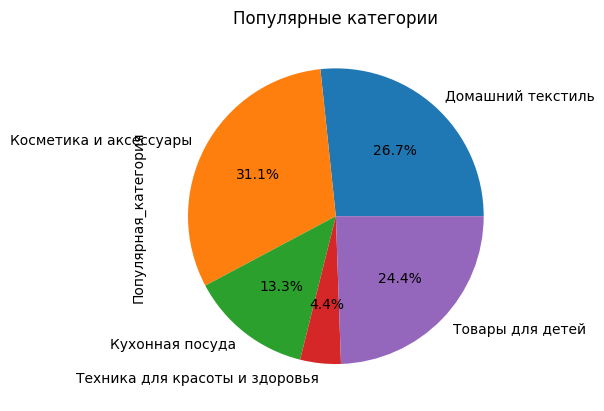

In [68]:
r_l_gb = ros_low.groupby('Популярная_категория')['Популярная_категория'].count()

r_l_gb.plot(kind='pie',
            autopct='%1.1f%%',
            grid=True)

plt.title('Популярные категории')
plt.show()

In [69]:
r_l_gb_rev = ros_low.groupby('Популярная_категория')[['Выручка_текущий_месяц','Выручка_предыдущий_месяц', 
                                                      'Выручка_препредыдущий_месяц']].sum()

r_l_gb_rev['Дельта тек_пред'] = r_l_gb_rev['Выручка_текущий_месяц'] - r_l_gb_rev['Выручка_предыдущий_месяц']

r_l_gb_rev['Дельта пред_препред'] = r_l_gb_rev['Выручка_предыдущий_месяц'] - r_l_gb_rev['Выручка_препредыдущий_месяц']
r_l_gb_rev

,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Дельта тек_пред,Дельта пред_препред
Популярная_категория,,,,,
Домашний текстиль,70321.9,67276.0,55711.0,3045.9,11565.0
Косметика и аксесcуары,80009.4,74773.0,66727.0,5236.4,8046.0
Кухонная посуда,35160.9,32576.5,27997.0,2584.4,4579.5
Техника для красоты и здоровья,9535.7,8952.0,9287.0,583.7,-335.0
Товары для детей,62335.1,56053.5,51963.0,6281.6,4090.5


Техника для красоты и здоровья, ожидаемо, оказывается наименее популярной категорией. В этой же категории можем отметить снижение по выручке в предыдущем месяце, однако отмечаем, что в текущем значение уже превысило препредыдущий месяц.

Соответственно, делаем вывод о том, что не смотря на высокие и крайне высокие риски снижения активности, выручка с таких клиентов не падает. Однако снижаются темпы роста выручки т.к. дельта за предыдущий и препредыдущий периоды по всем категориям (кроме двух) заметно выше.

Рассмотрим, как ведет себя рентабельность и прибыль в разбивке по категориям.

In [70]:
r_l_gb_prof = ros_low.groupby('Популярная_категория')[['Прибыль', 'ROS']].mean()

r_l_gb_prof 

,Прибыль,ROS
Популярная_категория,,
Домашний текстиль,3.520833,0.065807
Косметика и аксесcуары,3.414286,0.064679
Кухонная посуда,2.965000,0.055399
Техника для красоты и здоровья,2.835000,0.062666
Товары для детей,3.221818,0.062668


Крайне близкие и достаточно низкие значения. В среднем, все товары в каждой из категорий дали 5,5 - 6,6% рентабельности. Возможно в данном случае ключевым являются акции, которые привели к снижению рентабельности и оконание которых привело к снижению общей активности клиентов.

In [71]:
#Т.к. по анализу данных помним о том, что доли акционных покупок распределяются между 2 "островами", берем медиану
r_l_gb_sale =  ros_low.groupby('Популярная_категория')[['Акционные_покупки','ROS']].median()

r_l_gb_sale 

,Акционные_покупки,ROS
Популярная_категория,,
Домашний текстиль,0.375,0.064027
Косметика и аксесcуары,0.315,0.064694
Кухонная посуда,0.935,0.058364
Техника для красоты и здоровья,0.335,0.062666
Товары для детей,0.360,0.061706


В данном случае уже можем отметить заметный перекос в категории Кухонной посуды. Хотя категория составляет только 13,3% и занимает 4 место по популярности, отметим максимальную медианную долю ~94% при минимальной из всех ROS 5,8%. Соответственно, в данной категории допустимо сделать вывод о снижении рентабельности продаж в связи с чрезмерным количеством купленных по акции товаров, т.к. выручка при этом не снизилась в сравнении с предыдущим периодами. Т.к нет конкретики о том, что конкретно закладывается в данную метрику, можем предположить, что клиенты стали приобретать меньше товаров (в количественном выражении) реже оставлять отзывы и участвовать в программах лояльности, в том случае предполагае, что снижение активности данных клиентов может быть связано с окончанием действия акций на интересующие их товары, что уменьшило количество покупок (при увеличении выручки) и активность на сайте.


Отметим, что по 2 из 3 самых популярных категорий (Товары для детей и Домашний текстиль) доля близка к 40%, что также является достаточно значимым показателем. Соответственно, в таком случае для данных клиентов также справедлива ранее обозначенная гипотеза.

Соответственно, в таком случае стоит рассмотреть возможность организации более сложных акций на товары данных категорий. Т.е. не просто снижение цены на определенный период времени, а предоставление, например, промокодов за оставленные отзывы на ранее приобретенные товары или предоставление скидок/подарков при покупке определенных товаров и/или на определенную сумму. Потенциальным риском в таком случае станет отказ части пользователей от участия в таких активностях и, возможно, их откладывание покупки на более длительный срок, однако потери в выручке и прибыли от таких клиентов потенциально возможно нивелировать за счет увеличения объемов продаж другим.

Наконец, рассмотрим количество маркетинговых активностей в разрезе разных категорий.

In [72]:
r_l_gb_mar =  ros_low.groupby('Популярная_категория')[['Маркет_актив_6_мес','Маркет_актив_тек_мес']].mean()

r_l_gb_mar

,Маркет_актив_6_мес,Маркет_актив_тек_мес
Популярная_категория,,
Домашний текстиль,3.500000,3.666667
Косметика и аксесcуары,3.828571,3.857143
Кухонная посуда,4.316667,4.166667
Техника для красоты и здоровья,2.150000,3.000000
Товары для детей,2.990909,4.272727


Логично предположить, что поступающие рекламные предложения клиенту напрямую зависят от его любимой категории товаров. В таком случае, отмечаем ощутимый рост в количетве предложений в категории Товары для детей. По этой же категории ранее могли отметить наибольший рост выручки за все 3 рассматриваемых периода, из чего делаем закономерный вывод, что этот рост связан с увеличением количества акций на товары. Это же, предположительно, привело к относительно большой доли акционных товаров у клиентов (36%).
Однако, не смотря на это, общая активность клиентов снизилась. Возможно, в данном случае это и послужилось причиной снижения активности на сайте, т.е. данные клиенты негативно восприняли увеличение частоты получения рекламы. Либо же клиенты стали реже заходить на сайт, пока не получат информацию о наличии акций.


Для оценки данной гипотезы рассмотрим данные в разрезе времени на сайте.

In [73]:
r_l_gb_time =  ros_low.groupby('Популярная_категория')[['Страниц_за_визит','минут_текущий_месяц', 
                                                        'минут_предыдущий_месяц']].mean()

r_l_gb_time

,Страниц_за_визит,минут_текущий_месяц,минут_предыдущий_месяц
Популярная_категория,,,
Домашний текстиль,3.833333,10.166667,10.416667
Косметика и аксесcуары,4.428571,10.714286,10.785714
Кухонная посуда,3.833333,10.666667,10.833333
Техника для красоты и здоровья,5.500000,10.000000,11.500000
Товары для детей,4.636364,8.818182,8.818182


Количество проведенных минут на сайте у клиентов с любимой категорией Товары для детей не изменилось, соответственно увеличение количества маркетинговых коммуникаций не повлияло на время на сайте, увеличило выручку, но все равно снизило активность. Вероятно, теперь клиенты иначе распределяют проводимое на сайте время.


В целом, из всех категорий видим заметное изменение только по наименнее популярной категории - Техника для красоты и здоровья, время активности покупателей по которой уменьшилось.

По итогу анализа сегмента клиентов с низкой рентабельностью продаж, но высокими рисками снижения активности можем сделать вывод о том, что:
- В категории Кухонной посуды наибольшая доля акционных покупок у клиентов (почти 94%) при минимальной из всех ROS 5,8%. Вероятно, низкая рентабельность вызвана чрезмерным количеством купленных по акции товаров, т.к. выручка при этом не снизилась в сравнении с предыдущим периодами.
- Отметим, что по 2 из 3 самых популярных категорий (Товары для детей и Домашний текстиль) доля акционных товаров также достаточно значима (близко к 40%).
- Рекомендуется проведение более сложных рекламных акций. Т.е. не просто снижение цены на определенный период времени, а предоставление, например, промокодов за оставленные отзывы на ранее приобретенные товары или предоставление скидок/подарков при покупке определенных товаров и/или на определенную сумму. 
- Потенциальным риском в таком случае станет отказ части пользователей от участия в таких активностях и, возможно, их откладывание покупки на более длительный срок, однако потери в выручке и прибыли от таких клиентов потенциально возможно нивелировать за счет увеличения объемов продаж другим.

## Итоговый вывод

Подведем итоги работы:
    
- Исходыне данные содержали небольшое количество орфографических ошибок, которые были исправлены. Пропусков в данных нет. Яных дубликатов также не обнаружено. 
- Однако по итогам анализа выявлено наличие 4 аномальных значений (3 с аномальным количеством доли акционных товаров и с отсутствующими данными о выручке за предыдущий и препредыдущий месяца; 1 с аномально высоким показателем выручки), в итоговый датафрейм они не попали, были удалены для более корректной работы модели.


- По итогу анализа данных, установлено, что почти у 40% клиентов снизился уровень покупательской активности. Предварительно сделан вывод, что ключевыми причинами может быть отсутствие акций на интересующие группы товаров, отметили снижение времени пребывания таких клиентов на сайте и различия в популярных категориях (клиенты с прежним уровнем активности больше доля товаров категории Мелкая бытовая техника и электроника, а при снижении - Косметика и аксессуары и Кухонная посуда).
- По итогу корреляционного анализа гипотезу отвернуть не удалось, т.к. наблюдается линейная зависимость между долей акционных товаров, количеством неоплаченных товаров и обратная зависимость со временем на сайте (количество минут и просмотренных страниц) при наличии прямой корреляции между временем на сайте и объемом выручки.


- Для поиска лучшей модели был построен пайплайн. 
- За основу взяли 4 модели: метод k-ближайших соседей(KNeighborsClassifier), дерево решений (DecisionTreeClassifier), логистическая регрессия (LogisticRegression) и классификация опорных векторов (SVC). Для каждой подбирались, по возможности, оптимальные гиперпараметры. 
- По итогу оценки 4 моделей, лучший результат дала модель дерева решений (DecisionTreeClassifier) с максимальной глубиной 11, количество объектов на 1 "листе" 7, а минимальное количество объектов на узле для разделения на классы - 9. Метрика ROC-AUC на тренировочных данных составила 87%, на тестовой 85%. Показатели относительно высокие, однако свидетельствуют о недообученности модели, т.е. текущих данных не хватило для более точного прогнозирования.


- Оценка важности признаков показала:
    - Малозначимые признаки для модели: тип сервиса, длительность (т.е. количество дней с момента регистрации на сайте). Также модель не сочла значимыми почти все категории товаров, кроме Мелкой быовой техники и электроники. Ранее также отмечали большую разницу в количестве людей с данной любимой категорией среди покупателей с прежним и снизившимся уровнями покупательской активности.
    - Неожиданно, что выручка за препредыдущий месяц оказалась более значима для модели, чем за предыдущий. Выручку за текущий месяц модель и вовсе не учитывает.
    - Наиболее значимые признаки: количество просмотренных страниц за визит и количествено минут, проведенное на сайте, а также доля акционных покупок. При этом именно количество сраниц за визит является наиболее решающим фактором, важность практически 0.5.
- Можем предположить, что ключевым фактором является не столько привлечение клиента зайти на сайт, сколько удержать его внимание и стимулировать его более длительное время потратить на изучение ассортимента. Согласно полученным данным, это может стать ключевым фактором при принятии решении о покупке.
- Однако возможно это связано с неоптимальной работой алогоритмов поиска и предложения товаров на сайте, в следствие чего покупателю необходимо больше времени на принятие решения.
- Тип сервиса и вовсе, насколько можем судить, не оказывает существенного влияния на покупательскую активность, как минимум в разрезе имеющихся данных. Соответственно, вероятно, в текущем виде он или не предоставляет достаточного количества преимуществ для постоянных покупателей(т.е. не работает на удержание) и носит номинальный характер, или же не влияет на объем покупок в целом (например, касается сопутствующих операций, такие как визуальные изменения сайта (ночной/дневной режим), псевдо закрытые распродажи и прочее). Следовательно, необходимо либо переработать значимость статусов, либо же не учитывать их в анализе.
- В дальнейшем рекомендовано также пересмотреть данные, на которых обучается модель с целью устранения задвоения данных (например, время пребывания на сайте), а также оценить, какие из еще имеющихся данных у компании могут быть более полезными при анализе с учетом уже полученных предварительных результатов. 


- Выделили 3 группы покупателей в зависимости от объема прибыли Low, Normal и High.
- Для анализа была выбрана группа Low, которая обычно включает в себя новых и уходящих покупателей, приносящи малую прибыль за счет малых объемов покупок.
- Однако по итогу анализа выявлено, что причиной низкой прибыли является низкая рентабельность продаж, т.е. при высоких показателях выручки (следовательно, и объемах) компания недополучает прибыль.
- Это может быть связано как с завышенными тратами (прямыми и сопутствующими), не заложенными в цену, так и с неоптимальной ценой товара. Т.е. ценовая стратегия на такие товары и/или клиентов (если по итогу точечного анализа самих клиентов будет выявлено наличие среди них оптовых покупателей, для которых устанавливаются слишком высокие скидки) неоптимальна и требует пересмотра.
- Либо же итоговый более глубокий анализ ценовой стратегии данной категории может показать, что это "имиджевые затраты", т.е. компания сознательно идет на недополучение прибыли с данной категории клиентов с целью, например, непрямой рекламы (например, поставка по низким ценам товаров социально значимым компаниям, таким как детские сады, школы). В таком случае следует оценить, насколько данные о таких клиентах необходимы при построении модели прогноза снижения или сохранения уровня покупательской активности. 


- По итогу анализа сегмента клиентов с низкой рентабельностью продаж, но высокими рисками снижения активности можем сделать вывод о том, что:
    - В категории Кухонной посуды наибольшая доля акционных покупок у клиентов (почти 94%) при минимальной из всех ROS 5,8%. Вероятно, низкая рентабельность вызвана чрезмерным количеством купленных по акции товаров, т.к. выручка при этом не снизилась в сравнении с предыдущими периодами.
    - По 2 из 3 самых популярных категорий (Товары для детей и Домашний текстиль) доля акционных товаров также достаточно значима (близко к 40%).
    - Рекомендуется проведение более сложных рекламных акций. Т.е. не просто снижение цены на определенный период времени, а предоставление, например, промокодов за оставленные отзывы на ранее приобретенные товары или предоставление скидок/подарков при покупке определенных товаров и/или на определенную сумму. 
    - Потенциальный риск: потеря части клиентов (либо снижение их выручки).
    - Рассматриваемая выгода: рост активности остальных клиентов, компенсация потерь ростом выручки и прибыли за счет других клиентов (т.к. в таком случае кленту сложнее расчитать размер получаемой выгоды, что позволяет в совокупности уменьшить размер реальной скидки для клиентов).